### Optimal control of the FHN model
This notebook shows how to compute the optimal control signal for the FHN model for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
fhn = FHNModel()

# Some parameters to define stimulation signals
dt = fhn.params["dt"]
duration = 8.
amplitude = 1.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(np.arange(0,duration-0.2, dt)) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
fhn.params["duration"] = duration
x_init = 0.
y_init = 0.
fhn.params["xs_init"] = np.array([[x_init]])
fhn.params["ys_init"] = np.array([[y_init]])

Target  (1, 2, 81)


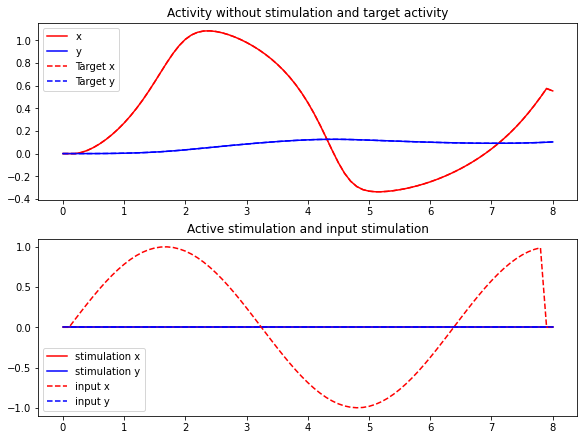

In [43]:
# We set the stimulus in x and y variables, and run the simulation
fhn.params["x_ext"] = input
fhn.params["y_ext"] = zero_input
fhn.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)
print("Target ", target.shape)

# Remove stimuli and re-run the simulation
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
#fhn.run()

# combine initial value and simulation result to one array
x = np.vstack( [x_init, fhn.x.T])
y = np.vstack( [y_init, fhn.y.T])

fig, ax = plt.subplots( 2,1, figsize=(8,6), constrained_layout=True)

# Plot the target (dashed line) and unperturbed activity
t_array = np.arange(0, duration+dt, dt)

ax[0].plot(t_array, x, label="x", color=color_x)
ax[0].plot(t_array, y, label="y", color=color_y)
ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
ax[0].legend()
ax[0].set_title("Activity without stimulation and target activity")

# Plot the target control signal (dashed line) and "initial" zero control signal
ax[1].plot(t_array, zero_input[0,:], label="stimulation x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], label="stimulation y", color=color_y)
ax[1].plot(t_array, input[0,:], linestyle='dashed', label="input x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], linestyle='dashed', label="input y", color=color_y)
ax[1].legend()
ax[1].set_title("Active stimulation and input stimulation")

plt.show()

In [44]:
# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=[1,2,100,200,300,400,500])

# We run 500 iterations of the optimal control gradient descent algorithm
fhn_controlled.optimize(10)

Compute control for a deterministic system
Cost in iteration 1: 12.894114922818574
(1, 2, 81)
Cost in iteration 2: 11.247274458295534
(1, 2, 81)
(1, 2, 81)
(1, 2, 81)
(1, 2, 81)
(1, 2, 81)
(1, 2, 81)
(1, 2, 81)
(1, 2, 81)
(1, 2, 81)


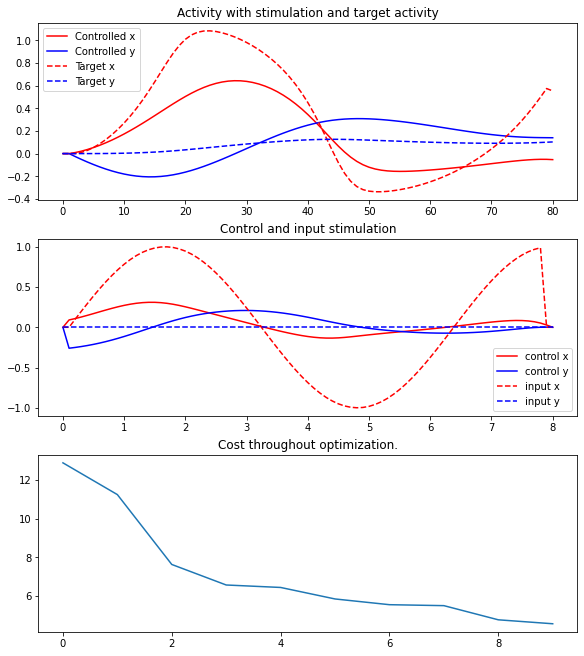

In [45]:

state = fhn_controlled.get_xs()
control = fhn_controlled.control

fig, ax = plt.subplots( 3,1, figsize=(8,9), constrained_layout=True)

# Plot the target (dashed line) and controlled activity
ax[0].plot(state[0,0,:], label="Controlled x", color=color_x)
ax[0].plot(state[0,1,:], label="Controlled y", color=color_y)
ax[0].plot(target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
ax[0].plot(target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
ax[0].legend()
ax[0].set_title("Activity with stimulation and target activity")

# Plot the target control signal (dashed line) and control signal after 500 iterations
ax[1].plot(t_array, control[0,0,:], label="control x", color=color_x)
ax[1].plot(t_array, control[0,1,:], label="control y", color=color_y)
ax[1].plot(t_array, input[0,:], linestyle='dashed', label="input x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], linestyle='dashed', label="input y", color=color_y)
ax[1].legend()
ax[1].set_title("Control and input stimulation")

# Plot the cost as function of iteration
ax[2].plot(fhn_controlled.cost_history)
ax[2].set_title("Cost throughout optimization.")
plt.show()

In [6]:
# Do another 100 iterations if you want to
# repeated execution will continue with further 100 iterations
fhn_controlled.optimize(100)

Cost in iteration 1: 0.004380687741814681
Cost in iteration 2: 0.004330184324394621
Cost in iteration 100: 0.0023681111908086657


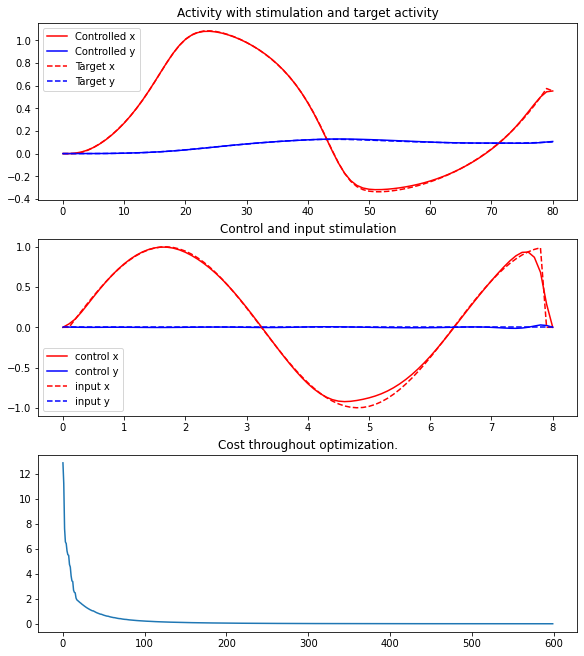

In [7]:

x_oc = np.vstack( [fhn_controlled.model.params["xs_init"], fhn_controlled.model.x.T])
y_oc = np.vstack( [fhn_controlled.model.params["ys_init"], fhn_controlled.model.y.T])

control = fhn_controlled.control

# Plot the results again
fig, ax = plt.subplots( 3,1, figsize=(8,9), constrained_layout=True)

ax[0].plot(x_oc, label="Controlled x", color=color_x)
ax[0].plot(y_oc, label="Controlled y", color=color_y)
ax[0].plot(x_target, linestyle='dashed', label="Target x", color=color_x)
ax[0].plot(y_target, linestyle='dashed', label="Target y", color=color_y)
ax[0].legend()
ax[0].set_title("Activity with stimulation and target activity")

ax[1].plot(t_array, control[0,:], label="control x", color=color_x)
ax[1].plot(t_array, control[1,:], label="control y", color=color_y)
ax[1].plot(t_array, input[0,:], linestyle='dashed', label="input x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], linestyle='dashed', label="input y", color=color_y)
ax[1].legend()
ax[1].set_title("Control and input stimulation")

ax[2].plot(fhn_controlled.cost_history)
ax[2].set_title("Cost throughout optimization.")
plt.show()

Let us know study a simple 2-node network of FHN oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

In [29]:
cmat = np.array( [[0., 1.], [0.5, 0.]] )  # diagonal elements are zero, connection stregth is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

In [49]:
fhn = FHNModel(Cmat=cmat, Dmat=dmat)

print(duration)

fhn.params["duration"] = 0.1 * duration
fhn.params["xs_init"] = np.vstack( [x_init, x_init] )
fhn.params["ys_init"] = np.vstack( [y_init, y_init] )

8.0


We will run a simulation with a sine stumulus in node 0, and define the resulting activity as the target again.

In [31]:
# We set the stimulus in x and y variables, and run the simulation
x_input_nw = np.vstack( [input, zero_input] )
zero_input_nw = np.vstack( [zero_input, zero_input] )
fhn.params["x_ext"] = x_input_nw
fhn.params["y_ext"] = zero_input_nw

fhn.run()

# Define the result of the stimulation as target
target = np.zeros(( fhn.params.N, len(fhn.output_vars), len(fhn.x[0,:])+1 ))
target[:,0,0] = fhn.params["xs_init"][:,0]
target[:,1,0] = fhn.params["ys_init"][:,0]
for t in range(len(fhn.x[0,:])):
    target[:,0,t] = fhn.x[:,t]
    target[:,1,t] = fhn.y[:,t] 

# Remove stimuli and re-run the simulation
fhn.params["x_ext"] = zero_input_nw
fhn.params["y_ext"] = zero_input_nw
fhn.run()

# combine initial value and simulation result to one array
x = np.zeros(( fhn.params.N, len(fhn.x[0,:])+1 ))
y = x.copy()
x[:,0] = fhn.params["xs_init"][:,0]
y[:,0] = fhn.params["ys_init"][:,0]
x[:,1:] = fhn.x
y[:,1:] = fhn.y   

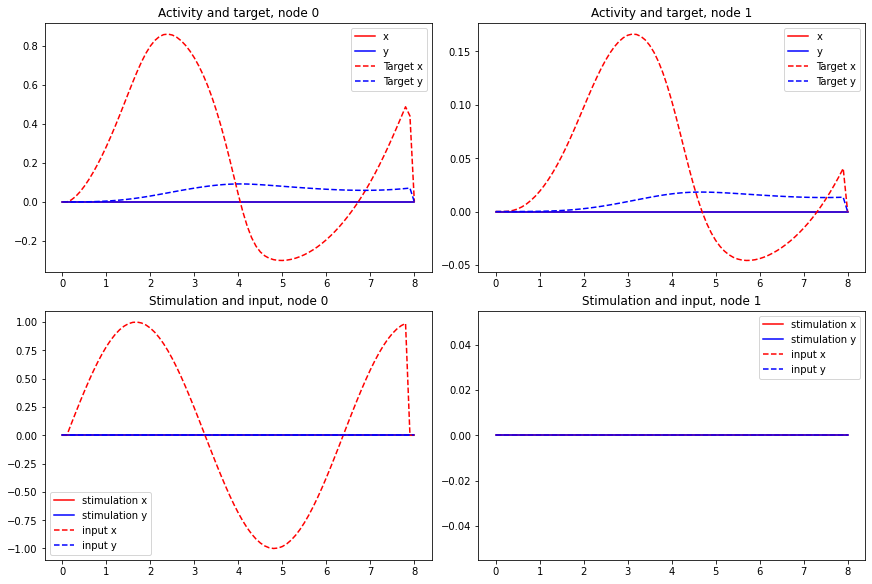

In [13]:
fig, ax = plt.subplots( 2,2, figsize=(12,8), constrained_layout=True)

# Plot the target (dashed line) and unperturbed activity
t_array = np.arange(0, duration+dt, dt)

for n in range(fhn.params.N):
    ax[0,n].plot(t_array, x[n,:], label="x", color=color_x)
    ax[0,n].plot(t_array, y[n,:], label="y", color=color_y)
    ax[0,n].plot(t_array, target[n,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0,n].plot(t_array, target[n,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0,n].legend()
    ax[0,n].set_title(f"Activity and target, node %s" % (n))

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1,n].plot(t_array, zero_input_nw[n,:], label="stimulation x", color=color_x)
    ax[1,n].plot(t_array, zero_input_nw[n,:], label="stimulation y", color=color_y)
    ax[1,n].plot(t_array, x_input_nw[n,:], linestyle='dashed', label="input x", color=color_x)
    ax[1,n].plot(t_array, zero_input_nw[n,:], linestyle='dashed', label="input y", color=color_y)
    ax[1,n].legend()
    ax[1,n].set_title(f"Stimulation and input, node %s" % (n))

plt.show()

In [127]:
fhn.params["duration"] = 1.
fhn.params["xs_init"] = np.array( [[0], [1]] )
fhn.params["ys_init"] = np.array( [[2], [3]] )

fhn.run()

# Define the result of the stimulation as target
target = np.zeros(( fhn.params.N, len(fhn.output_vars), len(fhn.x[0,:])+1 ))
target[:,0,0] = fhn.params["xs_init"][:,0]
target[:,1,0] = fhn.params["ys_init"][:,0]
for t in range(len(fhn.x[0,:])):
    target[:,0,t+1] = fhn.x[:,t]
    target[:,1,t+1] = fhn.y[:,t] 

nw = np.concatenate( (np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

print(target[1,0,:] - nw[1,0,:])

xsinit =  [[0.]
 [1.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
